# Your First Flow
## The Task
Let's begin our Normalizing Flow journey with a simple example! We'll train a flow to transform standard normal noise to samples from an arbitrary bivariate normal distribution.

That is, the base distribution is,
$$
\begin{aligned}
  X &\sim \mathcal{N}\left(\mu=\begin{bmatrix}
   0 \\
   0
\end{bmatrix}, \Sigma=\begin{bmatrix}
   1 & 0 \\
   0 & 1
\end{bmatrix} \right)
\end{aligned},
$$
the target distribution to learn is,
$$
\begin{aligned}
  Y' &\sim \mathcal{N}\left(\mu=\begin{bmatrix}
   5 \\
   5
\end{bmatrix}, \Sigma=\begin{bmatrix}
   0.5 & 0 \\
   0 & 0.5
\end{bmatrix} \right)
\end{aligned},
$$
and the task is to learn some bijection $g_\theta$ so that
$$
\begin{aligned}
  Y &\triangleq g_\theta(X) \\
  &\sim Y'
\end{aligned}
$$
approximately holds.

We will define our Normalizing Flow, $g_\theta$, by a single affine transformation,
$$
\begin{aligned}
  g_\theta(\mathbf{x}) &\triangleq \begin{bmatrix}
   \mu_1 \\
   \mu_2(x_1)
\end{bmatrix} + \begin{bmatrix}
   \sigma_1 \\
   \sigma_2(x_1)
\end{bmatrix}\otimes\begin{bmatrix}
   x_1 \\
   x_2
\end{bmatrix}.
\end{aligned}
$$
In this notation, $\mathbf{x}=(x_1,x_2)^T$, $\otimes$ denotes element-wise multiplication, and the parameters are the scalars $\mu_1,\sigma_1$ and the parameters of the neural networks $\mu_2(\cdot)$ and $\sigma_2(\cdot)$. (Think of the NNs as very simple shallow feedforward nets in this example.) This is an example of [Inverse Autoregressive Flow](/dev/bibliography#kingma2016improving).

There are several metrics we could use to train $Y$ to be close in distribution to $Y'$. Denote the target distribution of $Y'$ by $p(\cdot)$ and the learnable distribution of the normalizing flow, $Y$, as $q_\theta(\cdot)$ (in the following sections, we will explain how to calculate $q_\theta$ from $g_\theta$). Let's use the forward [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence),
$$
\begin{aligned}
\text{KL}\{p\ ||\ q_\theta\} &\triangleq \mathbb{E}_{p(\cdot)}\left[\log\frac{p(Y')}{q_\theta(Y')}\right] \\
&= -\mathbb{E}_{p(\cdot)}\left[\log q_\theta(Y')\right] + C,
\end{aligned}
$$
where C is a constant that does not depend on $\theta$. In practice, we draw a finite sample, $\{y_1,\ldots,y_M\}$, from $p$ and optimize a [Monte Carlo estimate](https://en.wikipedia.org/wiki/Monte_Carlo_integration) of the KL-divergence with stochastic gradient descent so that the loss is,
$$
\begin{aligned}
   \mathcal{L}(\theta) &= -\frac{1}{M}\sum^M_{m=1}\log(q_\theta(y_m))
\end{aligned}
$$

*So, to summarize, the task at hand is to learn how to transform standard bivariate normal noise into another bivariate normal distribution using an affine transformation, and we will do so by matching distributions with the KL-divergence metric.*

## Implementation
First, we import the relevant libraries:

In [1]:
import torch
import flowtorch.bijectors as B
import flowtorch.distributions as D
import flowtorch.parameters as P

The base and target distributions are defined using standard PyTorch:

In [2]:
base_dist = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2), torch.ones(2)), 
  1
)
target_dist = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2)+5, torch.ones(2)*0.5),
  1
)

Note the use of [`torch.distributions.Independent`](https://pytorch.org/docs/stable/distributions.html#independent) so that our base and target distributions are *vector valued*.

A Normalizing Flow is created in two steps. First, we create a "plan" for the flow as a [`flowtorch.bijectors.Bijector`](https://flowtorch.ai/api/flowtorch.bijectors.bijector) object,

In [3]:
# Lazily instantiated flow
bijector = B.AffineAutoregressive()

This plan is then made concrete by combining it with the base distributions, which provides the input shape, and constructing a [`flowtorch.distributions.Flow`](https://flowtorch.ai/api/flowtorch.distributions.flow) object, an extension of [`torch.distributions.Distribution`](https://pytorch.org/docs/stable/distributions.html#distribution):

In [4]:
# Instantiate transformed distribution and parameters
flow = D.Flow(base_dist, bijector)

At this point, we have an object, `flow`, for the distribution, $q_\theta(\cdot)$, that follows the standard PyTorch interface.

We can visualize samples from the base and target distributions as well as the flow before training:

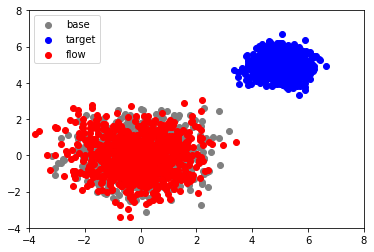

In [5]:
import matplotlib.pyplot as plt
plt.axis([-4., 8., -4., 8.])

base_samples = base_dist.sample((1000,))
target_samples = target_dist.sample((1000,))
flow_samples = flow.sample((1000,))

plt.scatter(base_samples[:,0], base_samples[:,1], label='base', c='grey')
plt.scatter(target_samples[:,0], target_samples[:,1], label='target', c='blue')
plt.scatter(flow_samples[:,0], flow_samples[:,1], label='flow', c='red')

plt.legend()
plt.show()

Since `flow` follows the standard inference for [`torch.distributions`](https://pytorch.org/docs/stable/distributions.html), it can be trained with the following code, which will be familiar to PyTorch users:

In [6]:
# Training loop
opt = torch.optim.Adam(flow.parameters(), lr=5e-3)
for idx in range(3001):
    opt.zero_grad()

    # Minimize KL(p || q)
    y = target_dist.sample((1000,))
    loss = -flow.log_prob(y).mean()

    if idx % 500 == 0:
        print('epoch', idx, 'loss', loss.item())

    loss.backward()
    opt.step()

epoch 0 loss 20.42441177368164
epoch 500 loss 3.5910611152648926
epoch 1000 loss 3.3313257694244385
epoch 1500 loss 3.024606704711914
epoch 2000 loss 2.4530959129333496
epoch 2500 loss 1.5909523963928223
epoch 3000 loss 1.478494644165039


Note how we obtain the learnable parameters of the normalizing flow from the `flow` object, which is a [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module). Visualizing samples after learning, we see that we have been successful in matching the target distribution:

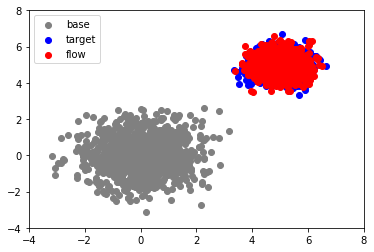

In [7]:
fig = plt.figure()
plt.axis([-4., 8., -4., 8.])

flow_samples = flow.sample((1000,))

plt.scatter(base_samples[:,0], base_samples[:,1], label='base', c='grey')
plt.scatter(target_samples[:,0], target_samples[:,1], label='target', c='blue')
plt.scatter(flow_samples[:,0], flow_samples[:,1], label='flow', c='red')

plt.legend()
plt.show()

Congratulations on training your first flow!

## Discussion

This simple example illustrates a few important points of FlowTorch's design:

Firstly, `Bijector` objects are agnostic to their shape. A `Bijector` object specifies *how the shape is changed* by the forward and inverse operations, and then calculates the exact shapes when it obtains knowledge of the base distribution, when `flow = dist.Flow(base_dist, bijector)` is run. Any neural networks or other parametrized functions, which also require this shape information, are not instantiated until the same moment. In this sense, a `Bijector` can be thought of as a lazy plan for creating a normalizing flow. The advantage of doing things this way is that the shape information can be "type checked" and does not need to be specified in multiple locations (ensuring these quantities are consistent).

Secondly, all objects are designed to have sensible defaults. We do not need to define the conditioning network for [`bijectors.AffineAutoregressive`](https://flowtorch.ai/api/flowtorch.bijectors.affineautoregressive), it will use a [MADE network](https://flowtorch.ai/dev/bibliography#germain2015made) with sensible hyperparameters and defer initialization until it later receives shape information.

Thirdly, there is compatibility, in as far as is possible, with standard PyTorch interfaces such as [`torch.distributions`](https://pytorch.org/docs/stable/distributions.html).
